  # The ALeRCE Light Curve Classifier: training the deployed model
  
 ```Author: Paula Sánchez-Sáez, Last updated: 20201109```
  
### Introduction:  
  
 The ALeRCE light curve classifier ([Sánchez-Sáez et al. 2020](https://arxiv.org/abs/2008.03311)) uses variability features computed from the ZTF alert stream, and colors obtained from AllWISE and ZTF photometry. It uses a Balanced  Random Forest algorithm with a two-level scheme, where the top level classifies each source as periodic, stochastic, and transient, and the bottom level further resolve each hierarchical class, yielding a total of 15 classes. This classifier corresponds to the first attempt to classify multiple classes of stochastic variables (including nucleus- and host-dominated active galaxies, blazars, young stellar objects, and cataclysmic variables) in addition to different classes of periodic and transient sources, using real data.

The first level (top level hereafter) consists of a single classifier which classifies every source as periodic, stochastic, or transient. The second level (bottom level hereafter) consists of three distinct classifiers: Transient, Stochastic, and Periodic. The classes considered by each of these three classifiers are the ones shown in Table 1 and Figure 2 of [Sánchez-Sáez et al. 2020](https://arxiv.org/abs/2008.03311). Each classifier in the bottom level is trained using a training subset having only those classes included in the primary top class (for instance, the Transient classifier only includes sources classified as SNIa, SNIbc, SNII, and SLSN). It is important to note that these four classifiers are independent and process the same input features set described in Section 3 of [Sánchez-Sáez et al. 2020](https://arxiv.org/abs/2008.03311). The final classification is constructed by multiplying the probabilities obtained for each class of the top level [$P_{top}(transient)$, $P_{top}(stochastic)$, and $P_{top}(periodic)$] with the individual probabilities obtained by their correspondent classifier in the bottom level. Namely, the probabilities of the Transient classifier ($P_{T}$) are multiplied by $P_{top}(transient)$, the probabilities of the Stochastic classifier ($P_{S}$) are multiplied by $P_{top}(stochastic)$, and the probabilities of the Periodic classifier ($P_{S}$) are multiplied by $P_{top}(periodic)$. We denote the product of these probabilities as $P$. For instance, the probability of a given source being an RRL corresponds to the product of its probability of being periodic (according to the top level) and its probability of being an RRL (according to the Periodic classifier): 
\begin{equation}
P(RRL) = P_{top}(periodic) \times P_P (RRL),
\end{equation}
while the probability of being a Blazar is computed as: 
\begin{equation}
P(Blazar) = P_{top}(stochastic) \times P_S(Blazar).
\end{equation}
Following this, the sum of the probabilities of the 15 classes for a given source adds up to one. Finally, the class of a given object is determined by selecting the class with the maximum $P$.
 

For more information about the ALeRCE broker, please visit http://alerce.science/, or read our publications:
* The Automatic Learning for the Rapid Classification of Events (ALeRCE) Alert Broker, [Förster et al. 2020, submitted to AJ](https://arxiv.org/abs/2008.03303)
* Alert Classification for the ALeRCE Broker System: The Real-time Stamp Classifier, [Carrasco-Davis et al. 2020, submitted to AJ](https://arxiv.org/abs/2008.03309)
* Alert Classification for the ALeRCE Broker System: The Light Curve Classifier, [Sánchez-Sáez et al. 2020, submitted to AJ](https://arxiv.org/abs/2008.03311)

### This notebook:

This notebook contains the code used to train the deployed model described in Section 5.3 of [Sánchez-Sáez et al. 2020](https://arxiv.org/abs/2008.03311), and can be used to reproduce the results presented in [Sánchez-Sáez et al. 2020](https://arxiv.org/abs/2008.03311). This notebook receives a file with the features already computed and a file with the labeled set. 

If you use this notebook, please cite our work: https://ui.adsabs.harvard.edu/abs/2020arXiv200803311S/exportcitation.



In [1]:
import numpy as np
import pandas as pd
from sklearn import preprocessing, model_selection, metrics, ensemble
import pickle
import itertools
import matplotlib.pyplot as plt
from collections import Counter
from imblearn.ensemble import BalancedRandomForestClassifier as RandomForestClassifier
from scipy.stats import randint as sp_randint
from sklearn.utils import class_weight

  ### Definition of names for plots and files

In [2]:

date = '20200609'

#names of files with features and labels for the training set (v7)

#labeled set
labels_file = './dfcrossmatches_prioritized_v7.0.1.csv'

#features
features_path = './'
features_file = features_path+'features_for_ML_with_WISE.parquet'


#where the RF models are saved
model_first_layer = 'final_BHRF_model/hierarchical_level_RF_model.pkl'
model_periodic_layer = 'final_BHRF_model/periodic_level_RF_model.pkl'
model_transient_layer = 'final_BHRF_model/stockastic_level_RF_model.pkl'
model_stochastic_layer = 'final_BHRF_model/transient_level_RF_model.pkl'

features_pickle = 'final_BHRF_model/features_RF_model.pkl'    
    
#confusion matrixes
conf_matrix_name_first_layer = 'stat_prob_hierRF_model_2/confusion_matrix_rf_model_2_hierarchical_layer_'+date
conf_matrix_name_second_layer = 'stat_prob_hierRF_model_2/confusion_matrix_rf_model_2_multiclass_'+date


#feature importances
feature_importance_name_first_layer = '../../paper_late_classifier/feature_importance_rf_model_2_hierarchical_layer_'+date+'.pdf'
feature_importance_name_periodic_layer = '../../paper_late_classifier/feature_importance_rf_model_2_periodic_layer_'+date+'.pdf'
feature_importance_name_transient_layer = '../../paper_late_classifier/feature_importance_rf_model_2_transient_layer_'+date+'.pdf'
feature_importance_name_stochastic_layer = '../../paper_late_classifier/feature_importance_rf_model_2_stochastic_layer_'+date+'.pdf'

### reading the training set files 

In [3]:
df_feat = pd.read_parquet(features_file)

df_labels = pd.read_csv(labels_file,index_col='oid')

#discarding infinite values
df_feat = df_feat.replace([np.inf, -np.inf], np.nan)

print(df_labels['class_source'].values.size)
print(df_feat.head())

173879
              MHAOV_Period_1  MHAOV_Period_2  Amplitude_1  Amplitude_2  \
oid                                                                      
ZTF17aaaaavn        0.106021        0.613572     0.078912     0.097860   
ZTF17aaaadjh        0.233443        0.233454     0.493980     0.463765   
ZTF17aaaadwo        0.060049        0.216873     0.090708     0.196542   
ZTF17aaaajjv      526.315748      555.555529     0.539600     0.566276   
ZTF17aaaakjt        0.148265        0.148265     0.564867     0.572449   

              AndersonDarling_1  AndersonDarling_2  Autocor_length_1  \
oid                                                                    
ZTF17aaaaavn           0.847902           0.673712               2.0   
ZTF17aaaadjh           1.000000           1.000000               1.0   
ZTF17aaaadwo           0.903625           0.993806               1.0   
ZTF17aaaajjv           1.000000           1.000000              14.0   
ZTF17aaaakjt           0.999907           

In [4]:
#defining taxonomy tree according to the taxonomy presented in Section 2.2 of the paper.
df_labels['class_original'] = df_labels['classALeRCE']
df_labels.loc[(df_labels['classALeRCE'] == 'RSCVn'), 'class_original'] = 'Periodic-Other'
df_labels.loc[(df_labels['class_original'] == 'SNIIn'), 'class_original'] = 'SNII'
df_labels.loc[(df_labels['class_original'] == 'EA'), 'class_original'] = 'E' #new name for paper
df_labels.loc[(df_labels['class_original'] == 'EB/EW'), 'class_original'] = 'E'#new name for paper
df_labels.loc[(df_labels['class_original'] == 'Ceph'), 'class_original'] = 'CEP'#new name for paper


df_labels = df_labels[(df_labels['class_source']!="ELL")]


bad_oid = ['ZTF18abslpjy','ZTF18acurqaw','ZTF18aboebre','ZTF18acvvsnu','ZTF19aaydpzi','ZTF19aatevrp','ZTF18abtteyy',
          'ZTF19aatmtne','ZTF18abtfgqr','ZTF18acetlrs','ZTF18abtmgfn','ZTF18acvvppd','ZTF18aczebty','ZTF18acefhxx',
          'ZTF18acvhggp','ZTF18adbktyj','ZTF18aarcypa','ZTF18accngee','ZTF18acwvcbz','ZTF19aacypbw','ZTF18acenqto',
          'ZTF19aapfnym','ZTF18acpefgk','ZTF18aavjcpf','ZTF18aceexmi','ZTF18accnmri','ZTF18acdvvgx',
          'ZTF18accnbgw','ZTF18acemhyb','ZTF19abqrrto','ZTF19aadolpe','ZTF18abxbmqh','ZTF20aacbwbm']

df_labels.drop(bad_oid,inplace=True)


#defining the classes included in the RF model

label_order = ['SNIa', 'SNIbc', 'SNII', 'SLSN','QSO','AGN', 'Blazar', 'YSO','CV/Nova',
               'LPV', 'E', 'DSCT', 'RRL', 'CEP','Periodic-Other']

labels = df_labels.loc[df_labels.class_original.isin(label_order)][["class_original"]]

#defining hierarchical classes:

labels['class_hierachical'] = labels['class_original']

labels.loc[ (labels['class_hierachical'] == 'LPV') | (labels['class_hierachical'] == 'Periodic-Other') | (labels['class_hierachical'] == 'E')  | (labels['class_hierachical'] == 'DSCT') | (labels['class_hierachical'] == 'RRL') | (labels['class_hierachical'] == 'CEP') , 'class_hierachical'] = 'Periodic'

labels.loc[(labels['class_hierachical'] == 'SNIa') | (labels['class_hierachical'] == 'SNIbc') | (labels['class_hierachical'] == 'SNII') | (labels['class_hierachical'] == 'SLSN'), 'class_hierachical'] = 'Transient'

labels.loc[(labels['class_hierachical'] == 'CV/Nova')  |(labels['class_hierachical'] == 'YSO') |     (labels['class_hierachical'] == 'AGN') |  (labels['class_hierachical'] == 'QSO') | (labels['class_hierachical'] == 'Blazar')  , 'class_hierachical'] = 'Stochastic'

cm_classes_hierachical = ['Transient','Stochastic','Periodic']
cm_classes_original = label_order

print(labels['class_hierachical'].values.shape)
labels.head()

(173041,)


,class_original,class_hierachical
oid,,
ZTF19abegncu,AGN,Stochastic
ZTF18acejdhu,AGN,Stochastic
ZTF18acdzene,AGN,Stochastic
ZTF18abwzuzw,AGN,Stochastic
ZTF19abmposz,AGN,Stochastic


In [5]:
#defining columns excluded from the df_nd table

rm_nd_cols = [
'n_det_1',
'n_det_2',
'n_pos_1',
'n_pos_2',
'n_neg_1',
'n_neg_2',
'first_mag_1',
'first_mag_2',
'MHPS_non_zero_1',
'MHPS_non_zero_2',
'MHPS_PN_flag_1',
'MHPS_PN_flag_2',
'mean_mag_1',
'mean_mag_2',
'min_mag_1',
'min_mag_2',
'W1','W2','W3','W4',  
'iqr_1',
'iqr_2', 
'delta_mjd_fid_1',
'delta_mjd_fid_2',
'last_mjd_before_fid_1',
'last_mjd_before_fid_2',
'g-r_ml',
'MHAOV_Period_1', 'MHAOV_Period_2',
]


df = labels.join(df_feat.drop(rm_nd_cols, axis=1),how='inner')


df = df.replace([np.inf, -np.inf], np.nan)

df_train = df.copy()
df_train = df_train.fillna(-999)
labels = df[['class_original','class_hierachical']]
df.drop(['Mean_1','Mean_2','class_original','class_hierachical'], axis=1, inplace=True)
df = df.fillna(-999)

print(len(labels['class_original'].values))

df.head()

123496


,Amplitude_1,Amplitude_2,AndersonDarling_1,AndersonDarling_2,Autocor_length_1,Autocor_length_2,Beyond1Std_1,Beyond1Std_2,Con_1,Con_2,...,rb,sgscore1,W1-W2,W2-W3,r-W3,r-W2,g-W3,g-W2,delta_period_1,delta_period_2
oid,,,,,,,,,,,,,,,,,,,,,
ZTF19aapcxhy,0.068704,0.052665,0.665183,0.501831,1.0,1.0,0.250000,0.307692,0.0,0.0,...,0.780000,0.013542,0.796,2.889,8.106832,5.217832,8.668390,5.779390,0.202128,1.155121
ZTF18abtmwvo,0.115177,-999.000000,0.996398,-999.000000,1.0,-999.0,0.428571,-999.000000,0.0,-999.0,...,0.717857,0.216488,0.807,2.964,-999.000000,-999.000000,9.126021,6.162021,0.081005,-999.000000
ZTF18acvgdfy,0.050608,-999.000000,0.353987,-999.000000,1.0,-999.0,0.500000,-999.000000,0.0,-999.0,...,0.683333,0.088542,0.606,2.876,-999.000000,-999.000000,8.483215,5.607215,0.023222,-999.000000
ZTF19aabvjsi,-999.000000,0.028547,-999.000000,0.494246,-999.0,1.0,-999.000000,0.333333,-999.0,0.0,...,0.683333,0.035875,0.938,3.017,8.099364,5.082364,-999.000000,-999.000000,-999.000000,0.529107
ZTF18aadyxlg,-999.000000,0.021935,-999.000000,0.543918,-999.0,1.0,-999.000000,0.500000,-999.0,0.0,...,0.683333,0.161542,0.959,3.021,8.041334,5.020334,-999.000000,-999.000000,-999.000000,0.277404


In [6]:
#which are the features included in the model?
print(np.array(df.columns))
print(len(np.array(df.columns)))

['Amplitude_1' 'Amplitude_2' 'AndersonDarling_1' 'AndersonDarling_2'
 'Autocor_length_1' 'Autocor_length_2' 'Beyond1Std_1' 'Beyond1Std_2'
 'Con_1' 'Con_2' 'Eta_e_1' 'Eta_e_2' 'ExcessVar_1' 'ExcessVar_2'
 'GP_DRW_sigma_1' 'GP_DRW_sigma_2' 'GP_DRW_tau_1' 'GP_DRW_tau_2' 'Gskew_1'
 'Gskew_2' 'Harmonics_mag_1_1' 'Harmonics_mag_1_2' 'Harmonics_mag_2_1'
 'Harmonics_mag_2_2' 'Harmonics_mag_3_1' 'Harmonics_mag_3_2'
 'Harmonics_mag_4_1' 'Harmonics_mag_4_2' 'Harmonics_mag_5_1'
 'Harmonics_mag_5_2' 'Harmonics_mag_6_1' 'Harmonics_mag_6_2'
 'Harmonics_mag_7_1' 'Harmonics_mag_7_2' 'Harmonics_mse_1'
 'Harmonics_mse_2' 'Harmonics_phase_2_1' 'Harmonics_phase_2_2'
 'Harmonics_phase_3_1' 'Harmonics_phase_3_2' 'Harmonics_phase_4_1'
 'Harmonics_phase_4_2' 'Harmonics_phase_5_1' 'Harmonics_phase_5_2'
 'Harmonics_phase_6_1' 'Harmonics_phase_6_2' 'Harmonics_phase_7_1'
 'Harmonics_phase_7_2' 'IAR_phi_1' 'IAR_phi_2' 'LinearTrend_1'
 'LinearTrend_2' 'MHPS_high_1' 'MHPS_high_2' 'MHPS_low_1' 'MHPS_low_2'
 'MHPS_rati

In [7]:
#how many sources belong to each class?
for idx, cl in enumerate(label_order):
   print(cl, labels['class_original'][labels['class_original']==cl].shape[0])

SNIa 1272
SNIbc 94
SNII 328
SLSN 24
QSO 26168
AGN 4667
Blazar 1267
YSO 1740
CV/Nova 871
LPV 14076
E 37901
DSCT 732
RRL 32482
CEP 618
Periodic-Other 1256


Counter({'E': 37901, 'RRL': 32482, 'QSO': 26168, 'LPV': 14076, 'AGN': 4667, 'YSO': 1740, 'SNIa': 1272, 'Blazar': 1267, 'Periodic-Other': 1256, 'CV/Nova': 871, 'DSCT': 732, 'CEP': 618, 'SNII': 328, 'SNIbc': 94, 'SLSN': 24})
                number
E                37901
RRL              32482
QSO              26168
LPV              14076
AGN               4667
YSO               1740
SNIa              1272
Blazar            1267
Periodic-Other    1256
CV/Nova            871
DSCT               732
CEP                618
SNII               328
SNIbc               94
SLSN                24


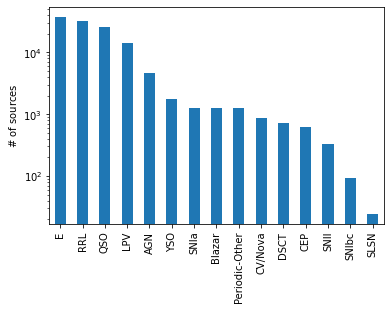

In [8]:
#plotting the number of sources per class for the labeled set
class_counts = Counter(labels['class_original'])
class_counts.most_common()
print(class_counts)


df_hist = pd.DataFrame.from_dict(class_counts, orient='index',columns=['number'])
df_hist = df_hist.sort_values(by=['number'],ascending=False)
print(df_hist)
df_hist.plot(kind='bar',legend=False)


plt.yscale('log')

plt.ylabel(r'$\#$ of sources')

plt.savefig('../../paper_late_classifier/paper_plots_2nd_version/number_sources_labeled_set.pdf',bbox_inches='tight')

  ### Defining functions to plot the confusion matrix and the feature importance

In [9]:
def plot_confusion_matrix(cm, classes, plot_name,
                          normalize=True,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = np.round((cm.astype('float') / cm.sum(axis=1)[:, np.newaxis])*100)
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    
    print(cm)

    fig, ax = plt.subplots(figsize=(12, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize = 17)
    plt.yticks(tick_marks, classes, fontsize = 17)

    #fmt = '.2f' if normalize else 'd'
    fmt =  'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "%d"%  (cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",fontsize = 16)

    plt.tight_layout()
    plt.ylabel('True label',fontsize = 18)
    plt.xlabel('Predicted label',fontsize = 18)
    plt.savefig(plot_name, bbox_inches='tight')
    #plt.close()
    


def plot_feature_importances(model, feature_names,feature_importances_name):
    I = np.argsort(model.feature_importances_)[::-1]
    I = I[0:60]
    for i in I[0:30]:
        print(feature_names[i], "& %.3f" % (model.feature_importances_[i]))
    fig, ax = plt.subplots(figsize=(16, 5), tight_layout=True)
    x_plot = np.arange(len(I))
    plt.xticks(x_plot, [feature_names[i] for i in I], rotation='vertical')
    ax.bar(x_plot, height=model.feature_importances_[I]);
    plt.savefig(feature_importances_name, bbox_inches='tight')
    #plt.close()

### Pre-processing training data

In [10]:
Y_hierarchical = labels['class_hierachical']
Y_original = labels['class_original']

print(len(labels['class_hierachical'].values))
print(len(labels['class_original'].values))
X_hierarchical = df

#splitting training set
X_train_hierarchical, X_test_hierarchical, y_train_hierarchical, y_test_hierarchical, y_train_original, y_test_original  = model_selection.train_test_split(X_hierarchical,
          Y_hierarchical, Y_original, test_size=0.2, stratify=Y_original)


# separating training sets for sub-classes
X_train_periodic = X_train_hierarchical.loc[y_train_hierarchical=='Periodic', :]
y_train_periodic = y_train_original.loc[y_train_hierarchical=='Periodic']

X_train_stochastic = X_train_hierarchical.loc[y_train_hierarchical=='Stochastic', :]
y_train_stochastic = y_train_original.loc[y_train_hierarchical=='Stochastic']

X_train_transient = X_train_hierarchical.loc[y_train_hierarchical=='Transient', :]
y_train_transient = y_train_original.loc[y_train_hierarchical=='Transient']

X_test_periodic = X_test_hierarchical
X_test_stochastic = X_test_hierarchical
X_test_transient = X_test_hierarchical

print(len(y_train_periodic), len(y_train_stochastic), len(y_train_transient))

123496
123496
69651 27771 1374


In [57]:
print(X_train_hierarchical.index)
print(X_test_hierarchical.index)

np.save('final_BHRF_model/labels_training_sample', X_train_hierarchical.index.values)
np.save('final_BHRF_model/labels_testint_sample', X_test_hierarchical.index.values)

Index(['ZTF18acnnqmx', 'ZTF18aajxkux', 'ZTF18aajqttp', 'ZTF18abdkhzq',
       'ZTF18abvtqlk', 'ZTF18aazluiy', 'ZTF18abypodv', 'ZTF18absumxg',
       'ZTF17aaadycq', 'ZTF18aagteha',
       ...
       'ZTF18acpddvk', 'ZTF18abbwygc', 'ZTF18abaqxsf', 'ZTF18abmnjqn',
       'ZTF19abeyxcq', 'ZTF19acectth', 'ZTF19aamkvoo', 'ZTF18abcltjs',
       'ZTF18abmqufr', 'ZTF19aamwqwo'],
      dtype='object', name='oid', length=98796)
Index(['ZTF18aauqsiu', 'ZTF18abkbxre', 'ZTF18ablpepc', 'ZTF19aaqtlws',
       'ZTF18aaadtdc', 'ZTF18abxwetq', 'ZTF18abcralj', 'ZTF20aaoyqoz',
       'ZTF20aadayup', 'ZTF20aawkofv',
       ...
       'ZTF18aajsvpy', 'ZTF18abtxvlc', 'ZTF18acwynmj', 'ZTF18aaadvds',
       'ZTF20aahpzsh', 'ZTF18abcmsej', 'ZTF18abvfsrv', 'ZTF17aacqsrz',
       'ZTF18abcjqpo', 'ZTF19aaycprb'],
      dtype='object', name='oid', length=24700)


  ## Balanced random forest
  
  ### Top level: separating Periodic, Stochastic and Transients:

In [11]:
#Training first level of the RF model

rf_model_hierarchical = RandomForestClassifier(
            n_estimators=500,
            max_features='auto',
            max_depth=None,
            n_jobs=-1,
            bootstrap=True,
            class_weight='balanced_subsample',
            criterion='entropy',
            min_samples_split=2,
            min_samples_leaf=1)


rf_model_hierarchical.fit(X_train_hierarchical, y_train_hierarchical)

#testing first level performance

y_true, y_pred = y_test_hierarchical, rf_model_hierarchical.predict(X_test_hierarchical)
y_pred_proba_hier = rf_model_hierarchical.predict_proba(X_test_hierarchical)

classes_order_proba_hierarchical = rf_model_hierarchical.classes_
print(classes_order_proba_hierarchical)


print("Accuracy:", metrics.accuracy_score(y_true, y_pred))
print("Balanced accuracy:", metrics.balanced_accuracy_score(y_true, y_pred))

#Dumping trained model

features_hierarchical = list(X_train_hierarchical)
        
with open(model_first_layer, 'wb') as f:
            pickle.dump(
                rf_model_hierarchical,
                f,
                pickle.HIGHEST_PROTOCOL)

['Periodic' 'Stochastic' 'Transient']
Accuracy: 0.9874898785425101
Balanced accuracy: 0.9866961952421404


[[  343     0     1]
 [   21  6719   202]
 [   14    71 17329]]
Normalized confusion matrix
[[100.   0.   0.]
 [  0.  97.   3.]
 [  0.   0. 100.]]


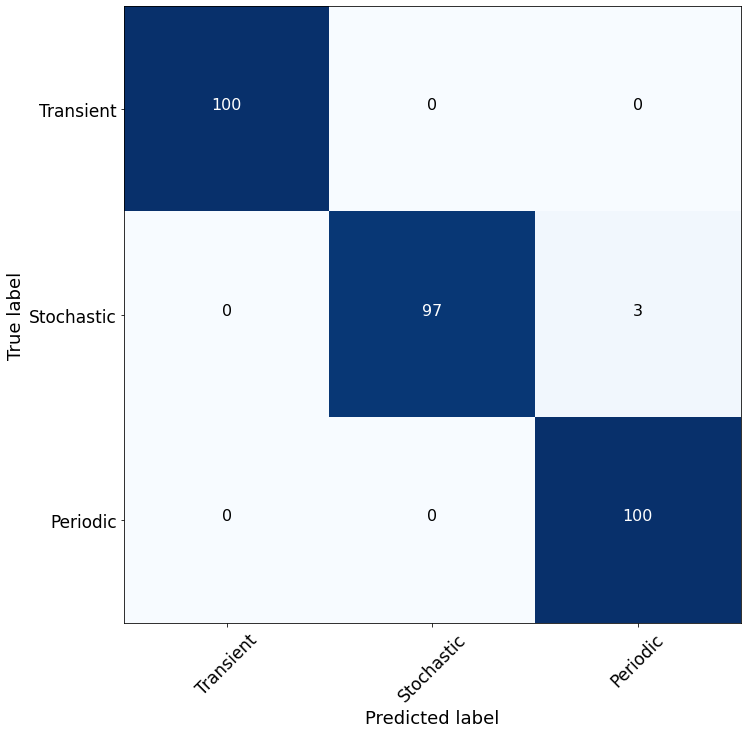

In [12]:
#plotting confusion matrix
cnf_matrix = metrics.confusion_matrix(y_true, y_pred, labels=cm_classes_hierachical)
print(cnf_matrix)
plot_confusion_matrix(cnf_matrix,cm_classes_hierachical,'../../paper_late_classifier/paper_plots_2nd_version/training_conf_matrix_hierarchical_level.pdf')

W1-W2 & 0.094
sgscore1 & 0.053
positive_fraction_2 & 0.050
positive_fraction_1 & 0.048
SPM_tau_rise_1 & 0.035
LinearTrend_2 & 0.032
SPM_chi_1 & 0.031
g-W2 & 0.031
g-W3 & 0.031
n_non_det_after_fid_2 & 0.026
W2-W3 & 0.025
SPM_beta_1 & 0.024
SPM_tau_rise_2 & 0.023
SPM_A_2 & 0.023
SPM_chi_2 & 0.020
SPM_A_1 & 0.019
r-W2 & 0.018
ExcessVar_1 & 0.017
ExcessVar_2 & 0.016
r-W3 & 0.014
Rcs_2 & 0.013
GP_DRW_sigma_2 & 0.013
SPM_tau_fall_1 & 0.013
Meanvariance_2 & 0.012
LinearTrend_1 & 0.012
SPM_beta_2 & 0.010
Pvar_2 & 0.010
MHPS_low_2 & 0.009
SF_ML_amplitude_2 & 0.009
g-r_max_corr & 0.009


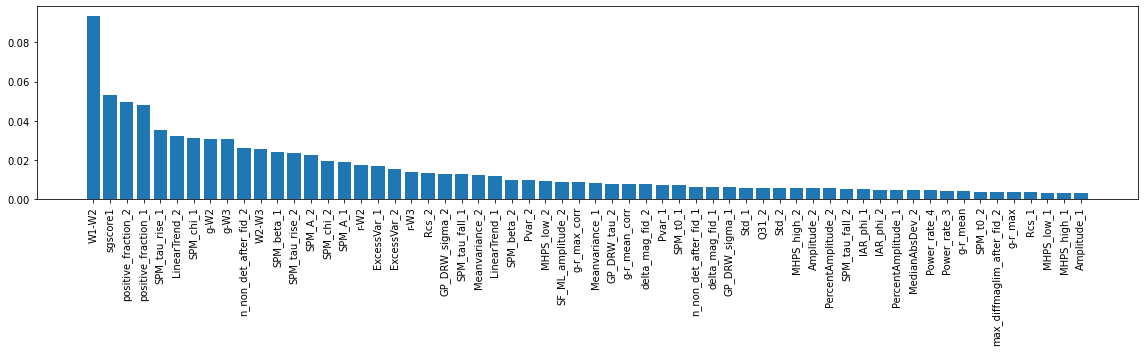

In [13]:
#plotting feature importance
plot_feature_importances(rf_model_hierarchical, features_hierarchical, 'final_BHRF_model/feature_ranking_hierarchical_level.pdf')

  ### Periodic classifier

In [14]:
#Training Periodic classifier

rf_model_periodic = RandomForestClassifier(
            n_estimators=500,
            max_features='auto',
            max_depth=None,
            n_jobs=-1,
            class_weight='balanced_subsample',
            bootstrap=True,
            criterion='entropy',
            min_samples_split=2,
            min_samples_leaf=1)

rf_model_periodic.fit(X_train_periodic, y_train_periodic)


# Applying periodic model to the test data
y_true_periodic, y_pred_periodic = y_test_original, rf_model_periodic.predict(X_test_periodic)
y_pred_proba_periodic = rf_model_periodic.predict_proba(X_test_periodic)

classes_order_proba_periodic = rf_model_periodic.classes_
print(classes_order_proba_periodic)

#Dumping trained model

features_periodic = list(X_train_periodic)

with open(model_periodic_layer, 'wb') as f:
            pickle.dump(
                rf_model_periodic,
                f,
                pickle.HIGHEST_PROTOCOL)

['CEP' 'DSCT' 'E' 'LPV' 'Periodic-Other' 'RRL']


89
Multiband_period & 0.089
g-W2 & 0.062
r-W2 & 0.034
g-r_max_corr & 0.030
g-W3 & 0.028
g-r_mean & 0.027
g-r_max & 0.025
GP_DRW_tau_1 & 0.023
g-r_mean_corr & 0.022
IAR_phi_1 & 0.022
Amplitude_1 & 0.017
ExcessVar_1 & 0.017
delta_mag_fid_1 & 0.016
Meanvariance_1 & 0.016
r-W3 & 0.016
Std_1 & 0.015
GP_DRW_sigma_1 & 0.015
GP_DRW_tau_2 & 0.012
PercentAmplitude_1 & 0.012
W1-W2 & 0.009
W2-W3 & 0.009
SF_ML_amplitude_1 & 0.009
SPM_A_1 & 0.009
Gskew_1 & 0.009
Q31_1 & 0.009
Autocor_length_1 & 0.009
IAR_phi_2 & 0.008
SF_ML_gamma_1 & 0.008
Amplitude_2 & 0.007
delta_mag_fid_2 & 0.007


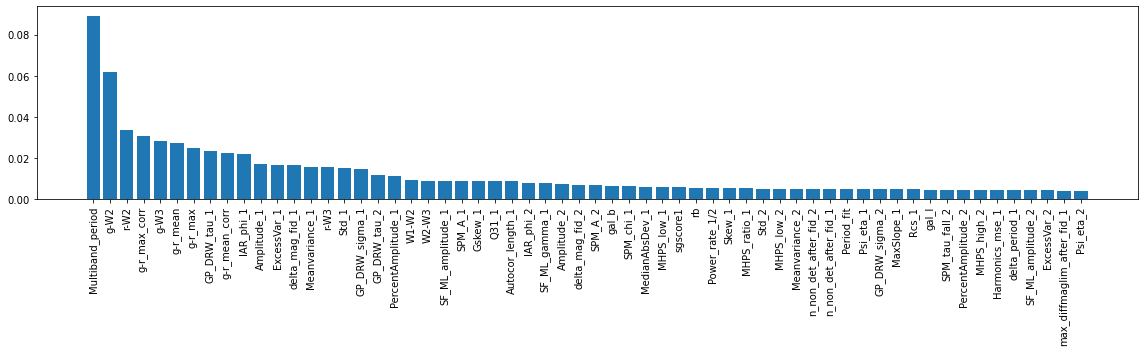

In [15]:
#plotting feature importance
print(len(feature_importance_name_first_layer))
plot_feature_importances(rf_model_periodic, features_periodic, 'final_BHRF_model/feature_ranking_periodic_level.pdf')

  ### Stochastic classifier

In [16]:
#Training Stochastic classifier

rf_model_stochastic = RandomForestClassifier(
            n_estimators=500,
            max_features=0.2,#'auto',
            max_depth=None,
            n_jobs=-1,
            bootstrap=True,
            class_weight='balanced_subsample',
            criterion='entropy',
            min_samples_split=2,
            min_samples_leaf=1)

rf_model_stochastic.fit(X_train_stochastic, y_train_stochastic)


# Applying stochastic model to the test data
y_true_stochastic, y_pred_stochastic  = y_test_original, rf_model_stochastic.predict(X_test_stochastic)
y_pred_proba_stochastic = rf_model_stochastic.predict_proba(X_test_stochastic)

classes_order_proba_stochastic = rf_model_stochastic.classes_
print(classes_order_proba_stochastic)

#Dumping trained model

features_stochastic = list(X_train_stochastic)


with open(model_stochastic_layer, 'wb') as f:
            pickle.dump(
                rf_model_stochastic,
                f,
                pickle.HIGHEST_PROTOCOL)

['AGN' 'Blazar' 'CV/Nova' 'QSO' 'YSO']


W1-W2 & 0.109
sgscore1 & 0.058
r-W2 & 0.049
g-r_mean_corr & 0.048
g-W2 & 0.046
gal_b & 0.045
g-W3 & 0.037
g-r_max_corr & 0.035
ExcessVar_2 & 0.033
Meanvariance_2 & 0.026
g-r_mean & 0.025
delta_mag_fid_2 & 0.024
r-W3 & 0.023
W2-W3 & 0.022
Amplitude_2 & 0.022
Std_2 & 0.015
g-r_max & 0.015
SPM_A_2 & 0.014
PercentAmplitude_2 & 0.013
SPM_A_1 & 0.012
ExcessVar_1 & 0.011
IAR_phi_1 & 0.010
GP_DRW_sigma_2 & 0.009
delta_mag_fid_1 & 0.009
Pvar_2 & 0.007
IAR_phi_2 & 0.007
GP_DRW_tau_2 & 0.007
GP_DRW_tau_1 & 0.007
MHPS_high_1 & 0.007
MHPS_low_1 & 0.006


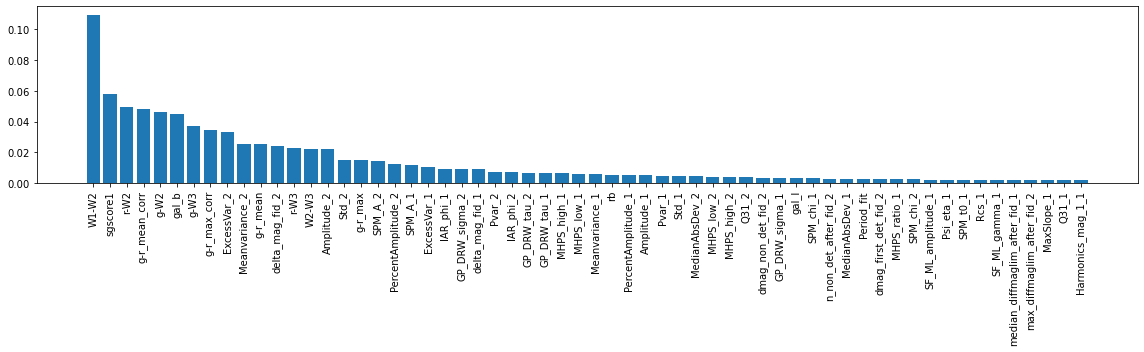

In [17]:
#plotting feature importance
plot_feature_importances(rf_model_stochastic, features_stochastic, 'final_BHRF_model/feature_ranking_stochastic_level.pdf')


  ### Transient classifier

In [18]:
#Training Transient classifier

rf_model_transient = RandomForestClassifier(
            n_estimators=500,
            max_features='auto',
            max_depth=None,
            n_jobs=-1,
            bootstrap=True,
            class_weight='balanced_subsample',
            criterion='entropy',
            min_samples_split=2,
            min_samples_leaf=1)

rf_model_transient.fit(X_train_transient, y_train_transient)

# Applying transient model to the test data
y_true_transient, y_pred_transient  = y_test_original, rf_model_transient.predict(X_test_transient)
y_pred_proba_transient = rf_model_transient.predict_proba(X_test_transient)

classes_order_proba_transient = rf_model_transient.classes_
print(classes_order_proba_transient)

#Dumping trained model

features_transient = list(X_train_transient)

with open(model_transient_layer, 'wb') as f:
            pickle.dump(
                rf_model_transient,
                f,
                pickle.HIGHEST_PROTOCOL)
        
with open(features_pickle, 'wb') as f:
            pickle.dump(
                features_transient,
                f,
                pickle.HIGHEST_PROTOCOL)

['SLSN' 'SNII' 'SNIa' 'SNIbc']


SPM_t0_1 & 0.033
SPM_beta_2 & 0.029
SPM_tau_rise_2 & 0.028
SPM_tau_rise_1 & 0.025
g-r_max & 0.023
SPM_t0_2 & 0.022
LinearTrend_2 & 0.019
AndersonDarling_2 & 0.018
SPM_beta_1 & 0.017
SPM_tau_fall_2 & 0.017
dmag_first_det_fid_1 & 0.015
MHPS_low_1 & 0.013
LinearTrend_1 & 0.013
g-r_mean & 0.012
MHPS_ratio_1 & 0.011
SPM_tau_fall_1 & 0.011
SPM_gamma_2 & 0.011
MHPS_ratio_2 & 0.010
Skew_2 & 0.009
sgscore1 & 0.009
SPM_gamma_1 & 0.009
Power_rate_2 & 0.009
IAR_phi_2 & 0.009
dmag_first_det_fid_2 & 0.009
IAR_phi_1 & 0.009
last_diffmaglim_before_fid_1 & 0.009
Period_fit & 0.008
Harmonics_mag_6_1 & 0.008
MHPS_low_2 & 0.008
Gskew_2 & 0.008


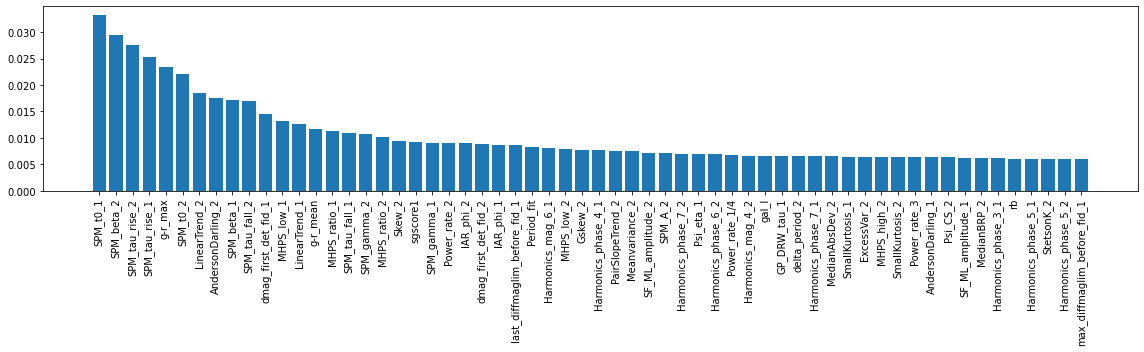

In [19]:
#plotting feature importance
plot_feature_importances(rf_model_transient, features_transient, 'final_BHRF_model/feature_ranking_transient_level.pdf')



 ## Putting al layers together  


In [20]:
# generating final probabilities

#multiplying probabilities of the top level with the other classifiers
prob_periodic = y_pred_proba_periodic*y_pred_proba_hier[:,np.where(classes_order_proba_hierarchical=='Periodic')[0][0]].T[:, np.newaxis]
prob_stochastic = y_pred_proba_stochastic*y_pred_proba_hier[:,np.where(classes_order_proba_hierarchical=='Stochastic')[0][0]].T[:, np.newaxis]
prob_trainsient = y_pred_proba_transient*y_pred_proba_hier[:,np.where(classes_order_proba_hierarchical=='Transient')[0][0]].T[:, np.newaxis]

#obtaining final probabilities matrix
prob_final = np.concatenate((prob_stochastic,prob_trainsient,prob_periodic),axis=1)

print(np.sum(prob_final,axis=1),np.mean(np.sum(prob_final,axis=1)),np.std(np.sum(prob_final,axis=1)))

#getting the ordered name of classes for prob_final
prob_final_class_names = np.concatenate((classes_order_proba_stochastic,classes_order_proba_transient,classes_order_proba_periodic))
print(prob_final_class_names)


class_final_proba = np.amax(prob_final,axis=1)
class_final_index = np.argmax(prob_final,axis=1)
class_final_name = [prob_final_class_names[x] for x in class_final_index]



[1. 1. 1. ... 1. 1. 1.] 1.0 7.765137331658304e-17
['AGN' 'Blazar' 'CV/Nova' 'QSO' 'YSO' 'SLSN' 'SNII' 'SNIa' 'SNIbc' 'CEP'
 'DSCT' 'E' 'LPV' 'Periodic-Other' 'RRL']


[[ 193   49   10    1    0    0    0    0    0    0    0    0    0    0
     1]
 [   5   11    2    1    0    0    0    0    0    0    0    0    0    0
     0]
 [   9   13   36    8    0    0    0    0    0    0    0    0    0    0
     0]
 [   0    0    0    5    0    0    0    0    0    0    0    0    0    0
     0]
 [   0    0    0    3 4569  405  234    4   18    0    1    0    0    0
     0]
 [   0    0    1    0   93  789   40    5    2    1    0    0    0    0
     2]
 [   0    0    0    0   35   22  191    0    3    2    0    0    0    0
     0]
 [   0    0    0    0    0    0    2  270    1   18    2    1    2   13
    39]
 [   3    2    2    0    0    0    1    3  124    1    8    9   16    4
     1]
 [   0    2    0    0    1    0    1   27    0 2749    0    0    0   18
    17]
 [   0    0    0    0    7    0    2   35   58    4 5575  460  261  275
   904]
 [   0    0    0    0    0    0    0    0    0    0    9  130    3    1
     3]
 [   0    0    1    0    6    0    1   1

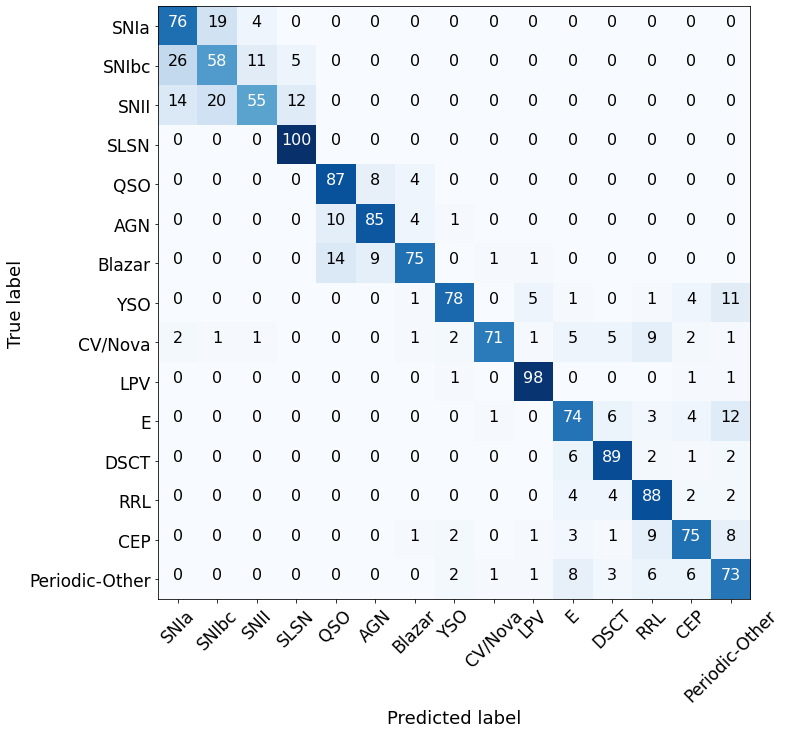

In [21]:
# generating confusion matrix for bottom level
cnf_matrix = metrics.confusion_matrix(y_test_original, class_final_name,labels=label_order)
print(cnf_matrix)
plot_confusion_matrix(cnf_matrix,label_order, '../../paper_late_classifier/paper_plots_2nd_version/conf_matrix_multiclass_level.pdf')

print("Accuracy:", "%0.2f" % metrics.accuracy_score(y_test_original, class_final_name))
print("Balanced accuracy:","%0.2f" %  metrics.balanced_accuracy_score(y_test_original, class_final_name))

print("macro precision: ","%0.2f" %  metrics.precision_score(y_test_original, class_final_name, average='macro'))
print("macro recall: ","%0.2f" %  metrics.recall_score(y_test_original, class_final_name, average='macro'))
print("macro F1: ","%0.2f" %  metrics.f1_score(y_test_original, class_final_name, average='macro'))

print(metrics.classification_report(y_test_original, class_final_name, digits=2))